# 卷积神经网络

我们已经实现了卷积层和池化层，现在来组合这些层，搭建进行手写数字识别的 CNN。这里的实现如下图所示。
网络的构成是“Convolution - ReLU - Pooling -Affine - ReLU - Affine - Softmax”，我们将它实现为名为 SimpleConvNet 的类。


In [1]:
# coding: utf-8
#卷积神经网络的python实现

import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """简单的ConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 输入大小（MNIST的情况下为784）
    hidden_size_list : 隐藏层的神经元数量的列表（e.g. [100, 100, 100]）
    output_size : 输出大小（MNIST的情况下为10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 指定权重的标准差（e.g. 0.01）
        指定'relu'或'he'的情况下设定“He的初始值”
        指定'sigmoid'或'xavier'的情况下设定“Xavier的初始值”
    """
    
    '''
    这里将由初始化参数传入的卷积层的超参数从字典中取了出来（以方便后面使用），然后，计算卷积层的输出大小。接下来是权重参数的初始化部分。
    学习所需的参数是第 1 层的卷积层和剩余两个全连接层的权重和偏置。将这些参数保存在实例变量的 params 字典中。
    将第 1 层的卷积层的权重设为关键字 W1，偏置设为关键字 b1。
    同样，分别用关键字 W2、b2 和关键字 W3、b3 来保存第 2 个和第 3 个全连接层的权重和偏置。
    
    从最前面开始按顺序向有序字典（OrderedDict）的 layers 中添加层。只有最后的 SoftmaxWithLoss 层被添加到别的变量 lastLayer 中。
    '''
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()
        

    '''用于推理的 predict 方法从头开始依次调用已添加的层，并将结果传递给下一层。
    在求损失函数的 loss 方法中，除了使用 predict 方法进行的 forward 处理之外，还会继续进行 forward 处理，直到到达最后的 SoftmaxWithLoss 层。'''
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """求损失函数
        参数x是输入数据、t是教师标签
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """求梯度（数值微分）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads
    
    '''
    参数的梯度通过误差反向传播法（反向传播）求出，通过把正向传播和反向传播组装在一起来完成。
    因为已经在各层正确实现了正向传播和反向传播的功能，所以这里只需要以合适的顺序调用即可。
    最后，把各个权重参数的梯度保存到 grads 字典中。
    '''

    def gradient(self, x, t):
        """求梯度（误差反向传播法）

        Parameters
        ----------
        x : 输入数据
        t : 教师标签

        Returns
        -------
        具有各层的梯度的字典变量
            grads['W1']、grads['W2']、...是各层的权重
            grads['b1']、grads['b2']、...是各层的偏置
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.2997658292461685
=== epoch:1, train acc:0.191, test acc:0.2 ===
train loss:2.2976939292157237
train loss:2.294979500079835
train loss:2.2869464207086425
train loss:2.2762563321579843
train loss:2.2680487838847982
train loss:2.2391743724389572
train loss:2.2373111274153916
train loss:2.1942367532859666
train loss:2.195069453199639
train loss:2.184659167032752
train loss:2.1489931490948546
train loss:2.0760491695615673
train loss:2.050364768794575
train loss:2.057782485366414
train loss:1.964743392590386
train loss:1.8721953209427034
train loss:1.831547405385943
train loss:1.8134421985375622
train loss:1.7471001043631313
train loss:1.6469086119056666
train loss:1.5483079840317902
train loss:1.4254511528776037
train loss:1.368705952806135
train loss:1.3138730109823231
train loss:1.1619208229078708
train loss:1.1676906446410462
train loss:0.9390009943606372
train loss:0.9975347226536381
train loss:1.0896355882373654
train loss:0.9329137566248794
train loss:0.7920763312291735
t

train loss:0.11503723323634402
train loss:0.3702603653074145
train loss:0.2329779704337151
train loss:0.33547984435078393
train loss:0.29414185333577764
train loss:0.17061465030864162
train loss:0.19363743555584834
train loss:0.24433457102680542
train loss:0.20178325492904026
train loss:0.271750338173601
train loss:0.29484142711015726
train loss:0.16228851425907911
train loss:0.2794032311555996
train loss:0.16903501072686744
train loss:0.2312080545481032
train loss:0.27323262102930534
train loss:0.17967053459159232
train loss:0.1562325813941826
train loss:0.11552836880347644
train loss:0.2139447253407502
train loss:0.42911668826619676
train loss:0.1974193649237805
train loss:0.3923162005511975
train loss:0.13250140735130123
train loss:0.21484734784706988
train loss:0.12290135550003659
train loss:0.22039588656347153
train loss:0.2838657632598781
train loss:0.23416041889530156
train loss:0.2375757273760441
train loss:0.22013877522590675
train loss:0.38160750359761036
train loss:0.2049346

train loss:0.17592957925870312
train loss:0.15920157703732385
train loss:0.08721852039446447
train loss:0.07478451706636267
train loss:0.11783389243672625
train loss:0.0951213992457998
train loss:0.07092223947423312
train loss:0.19053956409825198
train loss:0.07634419653928055
train loss:0.102052983083603
train loss:0.3153738801778173
train loss:0.06246714405351426
train loss:0.09354968545583892
train loss:0.10334950419431424
train loss:0.19058308458138495
train loss:0.08216589215923252
train loss:0.21552949595816664
train loss:0.06629568588061839
train loss:0.13902605711230032
train loss:0.18623646317135661
train loss:0.16826711903758576
train loss:0.1287523871630344
train loss:0.1109371915325269
train loss:0.1171181017612279
train loss:0.16142791950397656
train loss:0.13843096000391253
train loss:0.12260421385180562
train loss:0.10166284976673402
train loss:0.06256129356694261
train loss:0.11730296251305125
train loss:0.14370399719589486
train loss:0.26004378932572164
train loss:0.21

train loss:0.07142162866442553
train loss:0.09834632115535619
train loss:0.1137418387411278
train loss:0.07419341412254676
train loss:0.05759994761483161
train loss:0.0965219132767906
train loss:0.0712180738617087
train loss:0.11702847041122952
train loss:0.10745169625989702
train loss:0.10096202357984867
train loss:0.053121593720037656
train loss:0.09928729121357364
train loss:0.10551234749366975
train loss:0.05514516954389268
train loss:0.06337440651874424
train loss:0.045503012706797914
train loss:0.06006038484303899
train loss:0.1296942688472115
train loss:0.04604912685143395
train loss:0.049599818352415136
train loss:0.09724273740011029
train loss:0.2691621503166264
train loss:0.052677487009465035
train loss:0.0780116543859864
train loss:0.1136549196033012
train loss:0.06680357227156161
train loss:0.03591651690471756
train loss:0.05175641635064765
train loss:0.07446649004338517
train loss:0.09761383300070879
train loss:0.10087805121973187
train loss:0.11088493758857222
train loss:

train loss:0.03156254237640892
train loss:0.026637311295471474
train loss:0.057917995001907904
train loss:0.028677654595632793
train loss:0.041300030681993914
train loss:0.11330363773302446
train loss:0.0370509029400231
train loss:0.14071332050488924
train loss:0.10489631987921406
train loss:0.11528248277333752
train loss:0.10706953755675092
train loss:0.05001003017189412
train loss:0.04415341668775516
train loss:0.03453977481380711
train loss:0.11415808110901239
train loss:0.12385637557407424
train loss:0.10451715378708626
train loss:0.07951984708021106
train loss:0.03320336959495342
train loss:0.09234573531150586
train loss:0.03850473875014655
train loss:0.07390342373478695
train loss:0.059534163627349736
train loss:0.06329615905359509
train loss:0.03296395482790355
train loss:0.04587083404811598
train loss:0.07142186001678963
train loss:0.08535516735955437
train loss:0.188591995077004
train loss:0.0896408536231885
train loss:0.036331349102431625
train loss:0.019764197178483312
train

train loss:0.022090980973890013
train loss:0.03393515741890551
train loss:0.04434651573823909
train loss:0.019887675028766396
train loss:0.07132798617233355
train loss:0.06768278016480318
train loss:0.05745862198347534
train loss:0.09898144505523966
train loss:0.10086701002582477
train loss:0.05336090998610608
train loss:0.09962718190599375
train loss:0.046190003122724275
train loss:0.07982810635361787
train loss:0.043115932602544885
train loss:0.0355766949453766
train loss:0.05067002399114332
train loss:0.03432752174588036
train loss:0.024862504840691444
train loss:0.04893642773539451
train loss:0.08689800966514177
train loss:0.06273096184019124
train loss:0.07919722762124515
train loss:0.11331448142771251
train loss:0.03163834007403477
train loss:0.05856397243294368
train loss:0.0777579439511118
train loss:0.15830687592859952
train loss:0.04316253397006297
train loss:0.1473846773836011
train loss:0.050270472110236844
train loss:0.08817971542354153
train loss:0.11137062133484939
train

train loss:0.029475689432447365
train loss:0.042953925829396396
train loss:0.04229192662067802
train loss:0.052658749750039605
train loss:0.043559112627700534
train loss:0.04816326419700405
train loss:0.038513406472495036
train loss:0.04405232458852021
train loss:0.029936417939878713
train loss:0.016820974732966763
train loss:0.025469934949695416
train loss:0.044319297891515105
train loss:0.018928778185876703
train loss:0.030945060719580322
train loss:0.10230151828140319
train loss:0.06269922916833028
train loss:0.04464572093496104
train loss:0.049217677780603444
train loss:0.025821825998259443
train loss:0.03999117164923888
train loss:0.023336737527937725
train loss:0.07024095816487848
train loss:0.026600473679015076
train loss:0.058770438586974796
train loss:0.045852683875145475
train loss:0.040667720608171226
train loss:0.016335021840520447
train loss:0.05312411459448397
train loss:0.03708681677889969
train loss:0.030991959676456505
train loss:0.061072030207810456
train loss:0.06021

train loss:0.021395814699574633
train loss:0.021214544811588073
train loss:0.03913710760689348
train loss:0.07543836524511187
train loss:0.03527759393264099
train loss:0.007213572132114863
train loss:0.051932347381228317
train loss:0.1140672266547647
train loss:0.05873422708175599
train loss:0.07655844132164472
train loss:0.04446491355583977
train loss:0.026183703016825627
train loss:0.0381060884757619
train loss:0.04504253175685182
train loss:0.05154914556205774
train loss:0.007613884903039443
train loss:0.04701783021271425
train loss:0.01859904758691661
train loss:0.018651573737914845
train loss:0.04745508903377811
train loss:0.07642416115355907
train loss:0.1051588152935748
train loss:0.08254561491847777
train loss:0.03624512569678559
train loss:0.025234463499597178
train loss:0.16513703783540074
train loss:0.07492138901495907
train loss:0.1058794419700168
train loss:0.049799629728075084
train loss:0.0389596466613054
train loss:0.07245775676261045
train loss:0.16293721264622682
trai

train loss:0.039851811687240744
train loss:0.025222594159501427
train loss:0.04281469503534732
train loss:0.023848384613265345
train loss:0.035616489692015425
train loss:0.06413824098070771
train loss:0.1004930607181535
train loss:0.0193073405281403
train loss:0.049926865587476964
train loss:0.016490188723462692
train loss:0.03429269748208043
train loss:0.07809286597387645
train loss:0.05507761152328008
train loss:0.02987352623298925
train loss:0.024422171673058296
train loss:0.014063284338443114
train loss:0.03734300359352048
train loss:0.08133527407134983
train loss:0.039728507521342465
train loss:0.011014985726830025
train loss:0.07762907823491073
train loss:0.10796641557690306
train loss:0.021083927386499352
train loss:0.05868158347151106
train loss:0.10555209473827805
train loss:0.023837605712031525
train loss:0.03692529576689461
train loss:0.027108116621934398
train loss:0.047843051319258416
train loss:0.03160412721972047
train loss:0.036440775866265776
train loss:0.0646516552301

train loss:0.008994469458949357
train loss:0.028569232633986294
train loss:0.011041956984140767
train loss:0.040523606106724966
train loss:0.012092131560616453
train loss:0.02357447949749213
train loss:0.04678941695929412
train loss:0.011335432012836474
train loss:0.02127933224831975
train loss:0.15401150126837523
train loss:0.005474012040722418
train loss:0.040744716703265495
train loss:0.03236995163847623
train loss:0.040321957043741384
train loss:0.03434664037366138
train loss:0.006335239997390179
train loss:0.017272426636799395
train loss:0.011376053810914269
train loss:0.02509807274323791
train loss:0.010629351041023664
train loss:0.0074013023940050875
train loss:0.022836299559837517
train loss:0.08517602820080176
train loss:0.01052704381062877
train loss:0.03952803437694539
=== epoch:5, train acc:0.99, test acc:0.979 ===
train loss:0.07149996864754109
train loss:0.023659796730187508
train loss:0.037046145833909416
train loss:0.03549812204411816
train loss:0.02412452971514599
trai

train loss:0.10048480688496504
train loss:0.060654426796462095
train loss:0.0049272117418620795
train loss:0.014576390134183815
train loss:0.00917947719418181
train loss:0.03663174110482233
train loss:0.01651642371297405
train loss:0.00583482829873114
train loss:0.06159814624744027
train loss:0.011692865611457291
train loss:0.0072219346130503815
train loss:0.029574006070493278
train loss:0.017944168308458717
train loss:0.009024169706530133
train loss:0.015200127963808555
train loss:0.08152459456478851
train loss:0.0636043477544988
train loss:0.05225935268582026
train loss:0.023334184213214267
train loss:0.023198939899065345
train loss:0.03955395404757348
train loss:0.019739443183333892
train loss:0.026456627130262374
train loss:0.07690966546078751
train loss:0.026632045747663997
train loss:0.016468629695899906
train loss:0.02801334196202587
train loss:0.01662057103922318
train loss:0.011199696973801234
train loss:0.031125163326036116
train loss:0.030710926936232136
train loss:0.0244339

train loss:0.006884697575044867
train loss:0.005670849266810549
train loss:0.031642579519776545
train loss:0.014467716038026568
train loss:0.032462806229565745
train loss:0.017301632704232555
train loss:0.009954073377255443
train loss:0.004670176403715366
train loss:0.002780822634486214
train loss:0.06733863590715251
train loss:0.009831237668069932
train loss:0.014694959660789472
train loss:0.0038575888992179023
train loss:0.006864124846710113
train loss:0.012261350699610511
train loss:0.017389403402982995
train loss:0.02851012554715585
train loss:0.0030038091038429105
train loss:0.05382451409752896
train loss:0.010599652951885658
train loss:0.04851160773697056
train loss:0.01361134639066745
train loss:0.005463068753976951
train loss:0.04838260950197906
train loss:0.009707083817297802
train loss:0.01647404841539155
train loss:0.04014789307915869
train loss:0.10021868387984112
train loss:0.011867372922860659
train loss:0.007520191252013729
train loss:0.015823709394340295
train loss:0.01

train loss:0.04072220830819094
train loss:0.011432490551128391
train loss:0.011105317632567072
train loss:0.01235720851245369
train loss:0.004336995458151554
train loss:0.06191611002491695
train loss:0.009209782510986222
train loss:0.01652030854985973
train loss:0.01164758619219852
train loss:0.03387994141068948
train loss:0.009765526007898139
train loss:0.010431912337453815
train loss:0.005263285006009954
train loss:0.009462311006630931
train loss:0.005608540064234296
train loss:0.05532506513479467
train loss:0.00799641103428426
train loss:0.025876749332074164
train loss:0.007719741874485614
train loss:0.05133729322616164
train loss:0.03372115442557299
train loss:0.04615057362123534
train loss:0.012665687042938998
train loss:0.01716722273539435
train loss:0.002280525288051525
train loss:0.01824444702133887
train loss:0.020576000207423825
train loss:0.003366385656692805
train loss:0.05393939571623278
train loss:0.012192818755048733
train loss:0.021193376801315267
train loss:0.004735288

train loss:0.023057147562487685
train loss:0.020951519453765107
train loss:0.00897945298803742
train loss:0.013350073404907195
train loss:0.02400702814525645
train loss:0.025098406844674067
train loss:0.040432006693669614
train loss:0.015874110965558005
train loss:0.010445547274715767
train loss:0.04567113231052185
train loss:0.011295588298516996
train loss:0.019139973365469794
train loss:0.07091326633684719
train loss:0.027975880511324522
train loss:0.010525682459757215
train loss:0.06623606262563674
train loss:0.01517135623324501
train loss:0.0123956629076705
train loss:0.06921710110614442
train loss:0.013235775048898784
train loss:0.03946465102484307
train loss:0.021966065471289924
train loss:0.047735591105303114
train loss:0.031561700710188184
train loss:0.006331122463003935
train loss:0.041033956002002145
train loss:0.00835278318503148
train loss:0.006202627846690646
train loss:0.02257696294462092
train loss:0.008183999415880723
train loss:0.02505628062747017
train loss:0.01267889

train loss:0.028820389734680547
train loss:0.016183625129927888
train loss:0.004699965417972699
train loss:0.00757422236861007
train loss:0.008444006839868907
train loss:0.004184020716801328
train loss:0.021210715151019053
train loss:0.043865323259186226
train loss:0.005636873845704045
train loss:0.02103764896395587
train loss:0.015667858040582645
train loss:0.020117501202240443
train loss:0.004867222036852622
train loss:0.04028950550023927
train loss:0.004599730900077136
train loss:0.062358864827199566
train loss:0.0038043603191888335
train loss:0.007816886415741377
train loss:0.005590869713234667
train loss:0.022379408623419552
train loss:0.013654587396933746
train loss:0.0021916355148584067
train loss:0.0060126471519619295
train loss:0.008740185817338724
train loss:0.00782140591811534
train loss:0.0425297268920093
train loss:0.009631708323849276
train loss:0.0040251547889251955
train loss:0.011249965054564158
train loss:0.0014986282422344058
train loss:0.002338476947606907
train los

train loss:0.015808384432060122
train loss:0.01998054798042943
train loss:0.022105326174657183
train loss:0.014074018783358766
train loss:0.0037425709938831908
train loss:0.0028509428149486506
train loss:0.014785019459715824
train loss:0.0019403151465302848
train loss:0.003213975083564237
train loss:0.005093226806958672
train loss:0.022391921644776453
train loss:0.005088734110747383
train loss:0.004023897592399672
train loss:0.008676297814305905
train loss:0.01692339027151225
train loss:0.013509985255333297
train loss:0.033833072996343104
train loss:0.008146609177292161
train loss:0.011090961876511297
train loss:0.013796220335838301
train loss:0.023391303315816264
train loss:0.008492151859833099
train loss:0.011275778287201787
train loss:0.005911253203276487
train loss:0.029603924374469365
train loss:0.010300801481029768
train loss:0.031187281546218235
train loss:0.004665414010487381
train loss:0.00614998497372507
train loss:0.007805475280428515
train loss:0.02207794203381349
train los

train loss:0.001445128957699138
train loss:0.019836289830319022
train loss:0.008508764197643088
train loss:0.014071819956654172
train loss:0.0027306027389663273
train loss:0.02228255677177401
train loss:0.004266185106773845
train loss:0.0037683618413899118
train loss:0.015876747325161436
train loss:0.006002006539026361
train loss:0.010464262798395916
train loss:0.00838438762957193
train loss:0.007357071323605377
=== epoch:8, train acc:0.992, test acc:0.981 ===
train loss:0.0013145853435412448
train loss:0.03503787164653563
train loss:0.053171508211306555
train loss:0.010580569922342528
train loss:0.1437900883332695
train loss:0.004919920017410578
train loss:0.013683157962615253
train loss:0.004729671264492457
train loss:0.008764746529180953
train loss:0.0015069512214417396
train loss:0.00665005114167038
train loss:0.03691310156922281
train loss:0.03452513870855783
train loss:0.06778359214070073
train loss:0.004684960478244788
train loss:0.029450581122015946
train loss:0.003172075684195

train loss:0.004868017500022773
train loss:0.08851792099115878
train loss:0.019886421323696418
train loss:0.003610758874637396
train loss:0.0027756347277347088
train loss:0.0021544426723688085
train loss:0.009020644060555706
train loss:0.008602790869575726
train loss:0.004813243242643239
train loss:0.0016821728033986566
train loss:0.014562437197969005
train loss:0.015068086375753029
train loss:0.006023646899595093
train loss:0.009999503051250875
train loss:0.027949169018800086
train loss:0.001985779910661283
train loss:0.05235222717304557
train loss:0.008219228663674083
train loss:0.0044393622599017725
train loss:0.02387177793071923
train loss:0.018631924234634077
train loss:0.03213347398140209
train loss:0.009087429425426669
train loss:0.0017574274229456136
train loss:0.009825539876858318
train loss:0.021962616783477298
train loss:0.006271121225634102
train loss:0.012327534910732714
train loss:0.009309766570889047
train loss:0.006020575456154702
train loss:0.02594135818371482
train lo

train loss:0.0070526781067686535
train loss:0.0070599221453483026
train loss:0.004301999004280046
train loss:0.007396737719459502
train loss:0.01702315589069336
train loss:0.008733817969354806
train loss:0.0025845947254421885
train loss:0.02425142839560858
train loss:0.004478169233805472
train loss:0.023046013522190774
train loss:0.009905167986960098
train loss:0.005040680838883438
train loss:0.010420158799409074
train loss:0.0067984753482836155
train loss:0.0010592288815398185
train loss:0.024403632290798564
train loss:0.0165987899734903
train loss:0.0050420334912579835
train loss:0.0007585443608096508
train loss:0.0015981354038134548
train loss:0.005237631277562605
train loss:0.004909060293109524
train loss:0.014260033831833092
train loss:0.007839752021859216
train loss:0.010971037711342991
train loss:0.009681703550142362
train loss:0.01585892081533503
train loss:0.023572169485666497
train loss:0.03201426709910442
train loss:0.011482758443311189
train loss:0.024893383840638154
train 

train loss:0.005935144438777844
train loss:0.020722413653862782
train loss:0.005199008547290024
train loss:0.001100884103956931
train loss:0.0017023544087839968
train loss:0.0036777229772668417
train loss:0.004597827408820122
train loss:0.0034506708069882127
train loss:0.030219098954577923
train loss:0.0418549312595758
train loss:0.0009118950337951611
train loss:0.009586373400535161
train loss:0.01470646429630274
train loss:0.006983366654707231
train loss:0.0006415777398492005
train loss:0.005940952432294203
train loss:0.0024978339908175596
train loss:0.024667223841992027
train loss:0.007660434191671152
train loss:0.002672324704008343
train loss:0.08366021119535709
train loss:0.00281924386279772
train loss:0.031231608869209296
train loss:0.008235352998977933
train loss:0.0021516379247993765
train loss:0.0028871868888135947
train loss:0.0015587838587055602
train loss:0.0014971496851663448
train loss:0.03823962481804092
train loss:0.012851703951942583
train loss:0.019375221550691192
trai

train loss:0.05654496045121661
train loss:0.009036419245781205
train loss:0.005641182070377868
train loss:0.00048448236856792065
train loss:0.002025415036772245
train loss:0.013402044002301407
train loss:0.00794628819018473
train loss:0.0076793452782081524
train loss:0.03542979636534396
train loss:0.0009940216002481577
train loss:0.007237643665998848
train loss:0.0017647754133138093
train loss:0.003553440924506566
train loss:0.04863436055597597
train loss:0.014384987911962457
train loss:0.006817704728178148
train loss:0.020814053430228387
train loss:0.01174170717840788
train loss:0.011862431071699346
train loss:0.00295536813939713
train loss:0.008418285462292676
train loss:0.0012648406887890372
train loss:0.002244328351547956
train loss:0.016016828931883394
train loss:0.011967294558881077
train loss:0.002232211915919239
train loss:0.010852190770640185
train loss:0.00676008059184232
train loss:0.002019201477233403
train loss:0.007156998396961893
train loss:0.011860432826839643
train los

train loss:0.004115069972925866
train loss:0.006120023106241006
train loss:0.0003979643051348308
train loss:0.0021954711814446736
train loss:0.0027848215594338
train loss:0.016499773384396562
train loss:0.003396652069619046
train loss:0.009781798183324785
train loss:0.011392259134454569
train loss:0.0034924626513231447
train loss:0.07707593197630082
train loss:0.00455323249983915
train loss:0.02177711191376646
train loss:0.0502456275132898
train loss:0.0037259728361697204
train loss:0.02387919467976869
train loss:0.0036877048769208796
train loss:0.003307268884214579
train loss:0.0005667556810128168
train loss:0.008247652779596996
train loss:0.0005677941944030793
train loss:0.03144278111863905
train loss:0.004888432675616863
train loss:0.001910893096530617
train loss:0.001626559291541814
train loss:0.0033914543032193796
train loss:0.001945763140953807
train loss:0.009723679340773207
train loss:0.01005874150986483
train loss:0.007105347966388561
train loss:0.016623227805310507
train loss

train loss:0.025970815578128928
train loss:0.0017955139733650605
train loss:0.009366921034404112
train loss:0.005572757399010326
train loss:0.0024701361456444795
train loss:0.002586219887174902
train loss:0.005360967155796681
train loss:0.0018237442915121818
train loss:0.002013657143995567
train loss:0.010384789675286481
train loss:0.00470879627921071
train loss:0.0008245014029170372
train loss:0.01715260664702938
train loss:0.02046976609059804
train loss:0.020743665488643592
train loss:0.0016557492891644979
train loss:0.005666828244811885
train loss:0.0017028833320203915
train loss:0.024776040570138064
train loss:0.001615014491229214
train loss:0.003777893034567154
train loss:0.003616159286104206
train loss:0.0012815940887871797
train loss:0.0048808176251103836
train loss:0.004474000463143612
train loss:0.0046616145607423715
train loss:0.006638966380828262
train loss:0.00516232594591588
train loss:0.0008743633218662784
train loss:0.0018230956134108111
train loss:0.02519976548003327
tr

train loss:0.004785350276355871
train loss:0.004200623643744646
train loss:0.005133138835409934
train loss:0.0008989428415184895
train loss:0.0016985735024900275
train loss:0.022410514360175268
train loss:0.005472311836752985
train loss:0.007407230784131874
train loss:0.006530143236529571
train loss:0.004992798213906516
train loss:0.014162527309325025
train loss:0.00022587450672340015
train loss:0.004218909794101755
train loss:0.024929664536190044
train loss:0.002843291091404528
train loss:0.002866492991703355
train loss:0.003704409383194376
train loss:0.0009812181282913535
train loss:0.009013489826040338
train loss:0.0277392684586214
train loss:0.014744687564336702
train loss:0.005530125415971009
=== epoch:11, train acc:0.996, test acc:0.989 ===
train loss:0.0030938368461825
train loss:0.022280550327118988
train loss:0.00048301371821357056
train loss:0.0028518620576022608
train loss:0.00700066024178066
train loss:0.009725026338238314
train loss:0.005140668498323183
train loss:0.006690

train loss:0.006741370760780573
train loss:0.002797667921255189
train loss:0.0012267130916281774
train loss:0.002346489611838745
train loss:0.001717160698704611
train loss:0.0022333955450806603
train loss:0.015028450710214114
train loss:0.011056083525238923
train loss:0.005007272973896501
train loss:0.006284817198849206
train loss:0.059669558745942465
train loss:0.00019939647285080898
train loss:0.0020751854268642573
train loss:0.007162167699422763
train loss:0.004310559617736109
train loss:0.0025767104438034465
train loss:0.0008872195862297787
train loss:0.0031449916670121284
train loss:0.00861608968561016
train loss:0.004706192060072365
train loss:0.002481853962825383
train loss:0.0037225245561112357
train loss:0.006235587005755055
train loss:0.008013685848113034
train loss:0.001921438070813397
train loss:0.03656576230088744
train loss:0.0029158469120950797
train loss:0.02019227464374948
train loss:0.0017250071687256918
train loss:0.011320122820782055
train loss:0.014225328610403825


train loss:0.0005676485657690941
train loss:0.0056187563029802
train loss:0.002049740312652041
train loss:0.0028589626765118015
train loss:0.005714495828609222
train loss:0.004982269879808322
train loss:0.03351060055921892
train loss:0.000852489018905963
train loss:0.005300397556461234
train loss:0.002572974053565681
train loss:0.013641814581048817
train loss:0.0022632633507941604
train loss:0.0033354657579963936
train loss:0.00384865856467528
train loss:0.0018619894733457694
train loss:0.006587846286595786
train loss:0.006646977823276441
train loss:0.0006183055905689118
train loss:0.01107592893856218
train loss:0.0013272018326266838
train loss:0.002241522603519193
train loss:0.006640644462967102
train loss:0.004557912436763259
train loss:0.01063496454866041
train loss:0.03799099678186258
train loss:0.007125674924677163
train loss:0.0020158182485500464
train loss:0.0014615795638592928
train loss:0.005096865602858618
train loss:0.006504523485819894
train loss:0.0008039154519526414
train

train loss:0.0010079953610524575
train loss:0.0026624150559168285
train loss:0.0035527674350283494
train loss:0.00686067293224312
train loss:0.0022793691291317655
train loss:0.015167083465950288
train loss:0.002562539938587338
train loss:0.0013775076973762293
train loss:0.006737842993899444
train loss:0.0022153197660347203
train loss:0.011333774811040396
train loss:0.0010965790184580399
train loss:0.0010585178449800605
train loss:0.0006925299400875208
train loss:0.0016932132106016987
train loss:0.0011098196452064247
train loss:0.00022951360249925154
train loss:0.00373516169260734
train loss:0.0011652098789561845
train loss:0.005158023015512532
train loss:0.002835384084574841
train loss:0.0023315580801623412
train loss:0.0005987720843603696
train loss:0.020720686210937863
train loss:0.0025788661695413297
train loss:0.007839895352438158
train loss:0.002791227631490353
train loss:0.0015499976210511664
train loss:0.007328707546551862
train loss:0.0025156082473081227
train loss:0.0017526214

train loss:0.00017053986822228006
train loss:0.004765921099937428
train loss:0.006524418258006644
train loss:0.00664860100345622
train loss:0.004039011060987537
train loss:0.0021871251377374025
train loss:0.0006780866662567056
train loss:0.0006375522017904166
train loss:0.002543810517337867
train loss:0.0008090201749602069
train loss:0.0013939023832798467
train loss:0.011654165854013182
train loss:0.0039464100166615845
train loss:0.0008741151169136149
train loss:0.00016643373527162073
train loss:0.0056125512232945065
train loss:0.0031810478131541376
train loss:0.0020540626155193882
train loss:0.000925825113765867
train loss:0.004673062320858844
train loss:0.006108324773947126
train loss:0.0003822811840981617
train loss:0.002482686240254944
train loss:0.008476787829011054
train loss:0.0025206330642188342
train loss:0.0014849174067306627
train loss:0.0011589037983215024
train loss:0.006475404049244071
train loss:0.006739736293432797
train loss:0.029876529938433455
train loss:0.0035334019

train loss:0.010150251208545638
train loss:0.003340922604592722
train loss:0.025566371175780197
train loss:0.023900364419834973
train loss:0.009717490546060338
train loss:0.0030663862638202286
train loss:0.0006941054358929837
train loss:0.0014254251042857557
train loss:0.0007214147969089466
train loss:0.0032970211752465024
train loss:0.005582761857192803
train loss:0.015401408182828353
train loss:0.007197915020291486
train loss:0.011457234328128221
train loss:0.003187401726340224
train loss:0.006657371741040419
train loss:0.006199541178616097
train loss:0.0035688652607888966
train loss:0.01727394241422271
train loss:0.006287033675534661
train loss:0.0010731022831711717
train loss:0.0038722477148375747
train loss:0.012222600137903659
train loss:0.029149540757490176
train loss:0.0017535554964105387
train loss:0.0029562934010455323
train loss:0.007271577826573355
train loss:0.004095835030662118
train loss:0.002457365920502911
train loss:0.006951209664173985
train loss:0.01250156094318338


train loss:0.004840672437455387
train loss:0.010603309319569805
train loss:0.01405958528777121
train loss:0.0013446842248657927
train loss:0.0015650714790883522
train loss:0.0004792694514658613
train loss:0.004553762408539328
train loss:0.004642036048031956
train loss:0.002933116764149653
train loss:0.004289207015709273
train loss:0.00042621553892895373
train loss:0.016677329184305447
train loss:0.002558376713558116
train loss:0.0009382242848052973
train loss:0.03164992733024961
train loss:0.0017013796357957028
train loss:0.02074634227286355
train loss:0.006432108487732916
train loss:6.928824636317821e-05
train loss:0.0015891095214497872
train loss:0.0038009165974655485
train loss:0.0013102734588243585
train loss:0.005176243551293922
train loss:0.0016071193943729928
train loss:0.010719509189761394
train loss:0.001086014334380743
train loss:0.004755588621183985
train loss:0.007601184404639662
train loss:0.0015497541733729486
train loss:0.004848488820693102
train loss:0.00271886683747867

train loss:0.0035716043472254215
train loss:0.002056710842666275
train loss:0.025638123999880923
train loss:0.0013966912875809133
train loss:0.00010793399780570901
train loss:0.002032271819361702
train loss:0.0006648560610141665
train loss:0.0066106855899484
train loss:0.0009746259660795186
train loss:0.00015483593146146504
train loss:0.0035523165376794073
train loss:0.0160214890382996
train loss:0.0014196643608795406
train loss:0.0024004694519496
train loss:0.0023771166375001294
train loss:0.004144725414202513
train loss:0.00030948880641808635
train loss:0.007429416790661964
train loss:0.045433312094561404
train loss:0.01979719026096137
train loss:0.0012867319684734307
train loss:0.003589662802745637
train loss:0.0024104232399408255
train loss:0.0014387095321836446
train loss:0.0018704772138050318
train loss:0.0032780343874329416
train loss:0.004910138877304463
train loss:0.003915173103349159
train loss:0.000912264852452242
train loss:0.0028004787337683724
train loss:0.008445657477221

train loss:0.0008924193291044566
train loss:0.005179783246980649
train loss:0.0003393934145762004
train loss:0.004190467997304138
train loss:0.0005177028510019899
train loss:0.0012681348411615959
train loss:0.009269760155509035
train loss:0.0022204120137151585
train loss:0.0009494259265028522
train loss:0.0002805899661065476
train loss:0.0012898830945051653
train loss:0.004512557989673927
train loss:0.001971561600669058
train loss:0.0021924797518546786
train loss:0.0044829197488097374
train loss:0.00041381067648996514
train loss:0.0003210359581322629
train loss:0.0013041748012845313
train loss:0.004184289744805006
train loss:0.006216856341160141
train loss:0.00010854208239791678
train loss:0.002115587343261551
train loss:0.00033602877035071143
train loss:0.0020603294681304837
train loss:0.003290815401839856
train loss:0.001470434069655234
train loss:0.001978358955465291
train loss:0.0018042584053194679
train loss:0.0006733768999866748
train loss:0.0016611872281699907
train loss:0.00127

train loss:0.0006389490930787281
train loss:0.001886548815049186
train loss:0.002355914825406001
train loss:0.0043317870077910145
train loss:0.0013018463322090079
train loss:0.001914335695573226
train loss:0.004802307160177866
train loss:0.0013810669794827818
train loss:0.003013022353365172
train loss:0.002248940839564116
train loss:0.0011355564614559206
train loss:0.003246058665530484
train loss:0.005214382435994131
train loss:0.0014306689733339752
train loss:0.0007676983299072816
train loss:0.010508278456457276
train loss:0.003093107939417949
train loss:0.00026964668259936523
train loss:0.0029741774076007966
train loss:0.0004857168756695475
train loss:0.0024466468157864282
train loss:0.0013861647082652154
train loss:0.0010150095815049864
train loss:0.007202358291013012
train loss:0.0004014484936201026
train loss:0.00032371717132784227
train loss:0.00026450868160153584
train loss:0.00044435161968369054
train loss:0.001890974442839214
train loss:0.020825693884132624
train loss:0.003177

train loss:0.06565640209370147
train loss:0.0021438147060268598
train loss:0.004724068892838304
train loss:0.0008972609920344507
train loss:0.0006618266681170924
train loss:0.00054104546315299
train loss:0.0058059217792859365
train loss:0.0009857442549780892
train loss:0.0006319370696998238
train loss:0.0002707537849174723
train loss:0.004111385025203987
train loss:0.0006940258267781031
train loss:0.004374673878993844
train loss:0.0002692189582886698
train loss:0.0006640164395553369
train loss:0.0031763536508082222
train loss:0.005506114633883837
train loss:0.0011754157557560276
train loss:0.0026536446828323867
train loss:0.009908608899755218
train loss:0.0008298125103741493
train loss:0.05649313639951495
train loss:0.0010326330876928543
train loss:0.0009531268770055906
train loss:0.0008249126385802412
train loss:0.0022727054566264323
train loss:0.0022304908473881517
train loss:0.026212286971025
train loss:0.0030052964672909765
train loss:0.00028561279911976567
train loss:0.00167010787

train loss:0.0005506474165127962
train loss:0.003334198825901241
train loss:0.0015669215211731135
train loss:0.00024575981994197653
train loss:0.00021017022436019793
train loss:0.00024763400404551034
train loss:0.002479907601364695
train loss:0.0011090006129474998
train loss:0.0017188106781669565
train loss:0.0006746270094213387
train loss:0.00018930839972633437
train loss:0.0023021304607969252
train loss:0.010635754332828174
train loss:0.0007344866046823462
train loss:0.001077560507970567
train loss:0.0009026277179547083
train loss:0.004649423276341529
train loss:0.0007744228463935671
train loss:0.0021065877185321557
train loss:0.0019493058969214502
train loss:0.0021341080133548806
train loss:0.002842029326572749
train loss:0.004844894799323551
train loss:0.0007321909589015145
train loss:0.0033559687995064224
train loss:0.0015708877821802312
train loss:0.0016379058834312032
train loss:0.012414882529734241
train loss:0.0013422083021544795
train loss:0.00042786793985499636
train loss:0.

train loss:0.00044295548224182577
train loss:0.0013682603971832494
train loss:0.0018138097526582395
train loss:0.004196863301386527
train loss:0.0011143576164189795
train loss:0.0004640453782672353
train loss:0.013242937028606166
train loss:0.0039221092134904085
train loss:0.007853519100152077
train loss:0.0002713610320707253
train loss:0.0028133688200828767
train loss:0.002983420215408067
train loss:0.0007961805186437093
train loss:0.0013018482921544863
train loss:0.0027380911484257992
train loss:0.0016553491179519782
train loss:0.001950567022125514
train loss:0.0009530308524342913
train loss:0.0006358373348200963
train loss:0.001253560521636529
train loss:0.0005472052358419877
train loss:0.0005128666232704787
train loss:0.003490760934747515
train loss:0.009129570454585442
train loss:0.001563750409264912
train loss:0.00037682571873277117
train loss:0.0013860270313732325
train loss:0.002106637094141512
train loss:0.0008255415426040646
train loss:4.7581871322246224e-05
train loss:0.0062

train loss:0.00029901476171461045
train loss:0.000399230452494055
train loss:0.0008598500487062943
train loss:0.0007425928303385278
train loss:0.00015427927586884465
train loss:0.0011605882636494113
train loss:0.0005995762674915684
train loss:0.00038434687041028593
train loss:0.0035311081409128446
train loss:0.0036098126635470745
train loss:2.3702015814303014e-05
train loss:0.0008822963220100513
train loss:0.00018712305139792956
train loss:0.0007176813741287416
train loss:0.004373806947122645
train loss:0.0024647218440186185
train loss:0.0030803576630162423
train loss:0.00022921769053347866
train loss:0.004600588995138993
train loss:0.00354899645328426
train loss:0.0002511383742397302
train loss:0.006945122617724002
train loss:0.0017733797504204793
train loss:0.008776182774188868
train loss:0.0015105497340404592
train loss:0.0011132099529354426
train loss:0.0004538068147859266
train loss:0.006765033996317271
train loss:0.00879445675483879
train loss:0.0006169941922164523
train loss:0.0

train loss:0.0012406468301681876
train loss:0.001967070574793647
train loss:0.005590570906362601
train loss:0.0030704846395292894
train loss:0.014659011952041284
train loss:0.011950462125405388
train loss:0.0030395225189481785
train loss:0.00043724557621932557
train loss:0.004363433966321111
train loss:0.0002761338287142572
train loss:0.0002908357379717804
train loss:0.01270076280267891
train loss:0.00041077840075635826
train loss:0.0005782737114524607
train loss:0.001145660803243071
train loss:0.007329783973246733
train loss:0.0001542201783519204
train loss:0.0011271029336834908
train loss:0.0014690432708284117
train loss:0.00043805439430459896
train loss:0.004870676377551716
train loss:0.005944057734301015
train loss:0.002489874080707105
train loss:0.0011598260946756988
train loss:7.999266288517115e-05
train loss:0.005430579603507445
train loss:0.003676226442822502
train loss:0.0012482972028817765
train loss:0.003522850317639326
train loss:0.0005820397790170541
train loss:0.000771668

train loss:0.0020698467954040965
train loss:0.00011889729628836615
train loss:0.009074366225092084
train loss:4.886905941187014e-05
train loss:0.0027614363416435172
train loss:0.0011644090075663325
train loss:0.0015960525050913916
train loss:0.0012182213953673877
train loss:0.0009610906580628223
train loss:0.0003862169563840872
train loss:0.0013208229383046251
train loss:0.00047540660616492695
train loss:0.0025761126288649633
train loss:0.00026697410550058457
train loss:0.00017856530337966356
train loss:0.0009623779828916669
train loss:0.0015246234656575033
train loss:0.0026524534824825087
train loss:0.00911329369686798
train loss:0.0029392017447628397
train loss:0.0013832372975196277
train loss:0.0037407408025846444
train loss:0.0027976025379918574
train loss:0.0021734183272960218
train loss:0.0012264462317475595
train loss:0.0056332818103624225
train loss:0.0015644952470847734
train loss:0.00013722620100795733
train loss:0.0001695823277819896
train loss:8.086301216094889e-05
train lo

train loss:0.00043201503830058547
train loss:0.0002932494545585975
train loss:0.001169947443376905
train loss:0.01297639479948381
train loss:0.005443489046613328
train loss:0.0001947439143331651
train loss:0.002007304066238935
train loss:0.001966072764843216
train loss:4.034766934312593e-05
train loss:0.0013909259262892832
train loss:0.001785554883913733
train loss:0.001335607532209326
train loss:0.000976700681079694
train loss:0.00014473122759978463
train loss:0.004090817789061804
train loss:0.0005877009677912026
train loss:0.0017410322504645235
train loss:0.0013341812859766614
train loss:0.0001655391170256585
train loss:0.0014663595916954786
train loss:0.0022032024466077803
train loss:0.006016131460197384
train loss:0.0007143621053085625
train loss:0.0007559088426359445
train loss:0.0019554716083345727
train loss:0.0021776823947093193
train loss:0.001234560134646935
train loss:0.00015630747106921224
train loss:0.0020023613381706957
train loss:0.0002452937217532233
train loss:0.000210

train loss:0.0010830468885727935
train loss:0.0002107883112011077
train loss:0.001865960092901949
train loss:0.002679894526279249
train loss:0.000596305496852002
train loss:0.00014231186280862554
train loss:0.00023498740375100556
train loss:0.0007306293976752732
train loss:0.0052249365439233945
train loss:0.0014971687574886778
train loss:0.005983943741854855
train loss:0.00012958018065379668
train loss:0.0007277466049427873
train loss:0.002560516144899441
train loss:0.0011569246777220865
train loss:0.00039414345747307305
train loss:0.002210848160158804
train loss:0.000140204357319376
train loss:0.0010258007728261803
train loss:0.0031930657449018313
train loss:0.0022302681485226053
train loss:0.00020822831835974314
train loss:0.0007527009535521005
train loss:0.003816697491951123
train loss:0.00935125782030351
train loss:0.0019031039315236216
train loss:0.002606298080569665
train loss:0.00219434681593894
train loss:0.0008491339658752809
train loss:0.00543319454608223
train loss:0.0069275

train loss:0.0007838362759253727
train loss:0.006479091482244998
train loss:0.00017146769322486276
train loss:9.594874864348206e-05
train loss:0.0012091705209717214
train loss:0.001117940232754677
train loss:0.0008495523206469748
train loss:0.00018503859243388933
train loss:0.004413871997113178
train loss:0.00031107313817072007
train loss:5.897051220500515e-05
train loss:0.0007999234480979022
train loss:6.271451288741531e-05
train loss:0.0019396044597329647
train loss:0.0036216738968318225
train loss:0.0024077489929196123
train loss:0.004380207924157534
train loss:0.0017239903492185641
train loss:0.001010066028821431
train loss:0.0008627469007969283
train loss:0.0016414745595497455
train loss:3.2592301886046396e-05
train loss:0.0032966535870645477
train loss:0.00013072769562874815
train loss:0.0019204085069648225
train loss:0.002820329036730367
train loss:0.00040904905247352014
train loss:0.00026647495948224783
train loss:0.005460169255611938
train loss:0.00012639612218711776
train los

train loss:0.006415930231624952
train loss:0.000152469410528139
train loss:5.090630333959972e-05
train loss:0.00040099972878198905
train loss:0.00016994776730761235
train loss:0.00012272925887663643
train loss:0.000342381002319334
train loss:5.321279469907761e-05
train loss:0.0037141460826237054
train loss:0.0005353041610146237
train loss:0.0015426067701283875
train loss:0.000724978708648454
train loss:0.0007659678281580393
train loss:0.0005385763567660815
train loss:0.0020191103253213057
train loss:0.002219741305529587
train loss:0.0007438683680815525
train loss:0.0015171459582331433
train loss:0.007075398408157834
train loss:0.0003313645217214901
train loss:0.0013141208255975935
train loss:0.0038984104627699046
train loss:0.0011636720497708117
train loss:0.00026749748902430397
train loss:0.0005440580408420035
train loss:0.00145409428504255
train loss:0.0002367719307700821
train loss:0.003079916916637004
train loss:0.00022120640138840507
train loss:0.005372780203716165
train loss:0.00

train loss:0.0005510532515661027
train loss:0.00010754564508371008
train loss:0.0011144158438009704
train loss:0.00025740354395773293
train loss:0.0002113163622065851
train loss:0.0011686433634655496
train loss:0.0015532681681905967
train loss:0.0014270391569326587
train loss:0.0017187135224246983
train loss:0.0024312059223781076
train loss:0.00037513886634196405
train loss:0.0006608375833513833
train loss:0.0005103060797925241
train loss:9.626084945921105e-05
train loss:0.0012871714858828387
train loss:0.00037236570135357286
train loss:0.001724680729643885
train loss:0.0012957701664453227
train loss:0.00042706163313202257
train loss:0.00011997428971237207
train loss:9.381616791571712e-05
train loss:0.00018648957200676647
train loss:0.0009925896561934773
train loss:0.005826524213418316
train loss:0.00015901513886180436
train loss:0.00041697004440575025
train loss:0.00028856276071456796
train loss:0.000810228116068168
train loss:0.00014261111932588252
train loss:0.00017450662091621815
t

train loss:0.0026696188351942535
train loss:5.9539602021100364e-05
train loss:2.6413623171311035e-05
train loss:0.0024633440457100834
train loss:0.00016903648363060013
train loss:0.0006918329093244438
train loss:0.00030695585621542536
train loss:0.0012614295713883944
train loss:0.0006647229276104164
train loss:0.0001599057911470893
train loss:0.0006260846958408887
train loss:0.0017149793479484677
train loss:0.0010189600073681675
train loss:0.0032140921717110004
train loss:0.0009984584387314414
train loss:0.12033427402025268
train loss:0.0032633798650852646
train loss:4.527093531437952e-05
train loss:0.0003053626511520456
train loss:0.0024855351777618344
train loss:0.00020442388067302048
train loss:0.0004464823276827451
train loss:0.0021708923980810215
train loss:0.00013454216032361726
train loss:3.3704548769641505e-05
train loss:0.00044944378308067544
train loss:0.0010365365270108198
train loss:0.001480618067064623
train loss:0.00011710340980319884
train loss:0.0007424905636536559
trai

train loss:0.0007555705698303069
train loss:0.0013205262517945221
train loss:0.0015117356434436143
train loss:0.00024524246221555636
train loss:0.0002244327882229699
train loss:0.0030333756623037666
train loss:0.0028218621609451306
train loss:6.684017070435872e-05
train loss:0.00031172115806269677
train loss:0.0028297030172301286
train loss:5.009646780189437e-05
train loss:0.0006169513191906411
train loss:0.000816633911575983
train loss:0.026919380204355622
train loss:8.124279492165734e-05
train loss:0.004746716553031942
train loss:0.0023822784833342795
train loss:0.0004140438775977994
train loss:0.001015656382138327
train loss:0.00023285776864323833
train loss:0.0006065508948847671
train loss:0.0004953685897904691
train loss:0.004034431450110956
train loss:0.0027020456103835034
train loss:0.005163533994033108
train loss:0.0005086208957900507
train loss:0.000704414998153529
train loss:0.002764436909504695
train loss:0.0006224136727829462
train loss:0.0001148671473361167
train loss:0.00

train loss:0.0006400482112833724
train loss:0.002413711931746683
train loss:0.0002024963141752395
train loss:8.36532742852469e-05
train loss:6.0673403699875856e-05
train loss:0.0005068265367971926
train loss:0.0013794548226428883
train loss:0.00019326719321723258
train loss:0.0012848174167320787
train loss:7.898436754780842e-05
train loss:0.0025375858937123014
train loss:0.00011425730491690481
train loss:0.0007930480877399732
train loss:0.002602386513798926
train loss:0.000574314004131685
train loss:0.001352837614143711
train loss:0.000142826442039533
train loss:0.0016759243670878478
train loss:0.0038943963096948575
train loss:0.005188652510592202
train loss:0.00024785295877502065
train loss:0.0018154190097151195
train loss:0.0007575717578615994
train loss:0.0006587801518635998
train loss:0.00017314552679097907
train loss:0.0013278421513274888
train loss:3.748687856404235e-05
train loss:0.00015470207008579432
train loss:0.001487014565240176
train loss:0.0033171977795018377
train loss:0

train loss:0.0011971318991036283
train loss:0.0018412231391073857
train loss:0.0014726369553277184
train loss:1.2272068992568254e-05
train loss:0.001849260428837766
train loss:0.00031435263553067713
train loss:0.0015414082922136226
train loss:1.9042886198774183e-05
train loss:6.007062092706354e-05
=============== Final Test Accuracy ===============
test acc:0.9899
Saved Network Parameters!


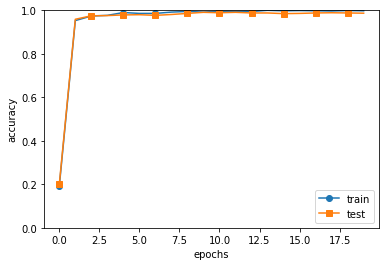

In [3]:
# coding: utf-8

#用SimpleConvNet训练手写数字识别
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 处理花费时间较长的情况下减少数据 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 2.CNN 的可视化
CNN 中用到的卷积层在“观察”什么呢？本节将通过卷积层的可视化，探索 CNN 中到底进行了什么处理。

### 第 1 层权重的可视化

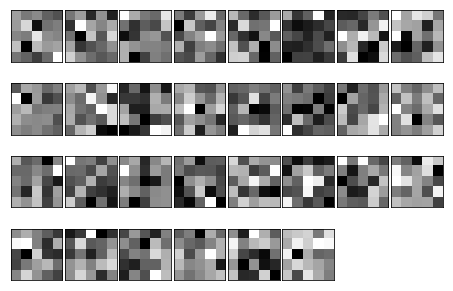

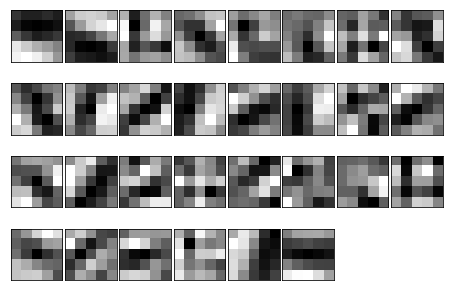

In [4]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 随机进行初始化后的权重
filter_show(network.params['W1'])

# 学习后的权重
network.load_params("params.pkl")
filter_show(network.params['W1'])

**学习前和学习后的第 1 层的卷积层的权重：虽然权重的元素是实数，但是在图像的显示上，统一将最小值显示为黑色（0），最大值显示为白色（255）**
第二个图中的有规律的滤波器在“观察”什么，答案就是它在观察边缘（颜色变化的分界线）和斑块（局部的块状区域）等。

### 基于分层结构的信息提取
<img src="img/convolution_info.png" width=80%>
<center>CNN 的卷积层中提取的信息。第1层的神经元对边缘或斑块有响应，第3层对纹理有响应，第5层对物体部件有响应，最后的全连接层对物体的类别有响应</center>

如果堆叠了多层卷积层，则随着层次加深，提取的信息也愈加复杂、抽象，这是深度学习中很有意思的一个地方。最开始的层对简单的边缘有响应，接下来的层对纹理有响应，再后面的层对更加复杂的物体部件有响应。也就是说，随着层次加深，神经元从简单的形状向“高级”信息变化。换句话说，就像我们理解东西的“含义”一样，响应的对象在逐渐变化。

# 3.具有代表性的 CNN

关于 CNN，迄今为止已经提出了各种网络结构。这里，我们介绍其中特别重要的两个网络，一个是在 1998 年首次被提出的 CNN 元祖 LeNet[20]，另一个是在深度学习受到关注的 2012 年被提出的 AlexNet。